# Event

In [1]:
import xarray
import numpy
import pandas
import climtas
import xesmf
import dask.array

We have a Dask dataset, and we'd like to identify periods where the value is above some threshold

In [2]:
time = pandas.date_range('20010101', '20040101', freq='D', closed='left')

data = dask.array.random.random((len(time),50,100), chunks=(90,25,25))
lat = numpy.linspace(-90, 90, data.shape[1])
lon = numpy.linspace(-180, 180, data.shape[2], endpoint=False)

da = xarray.DataArray(data, coords=[('time', time), ('lat', lat), ('lon', lon)], name='temperature')
da.lat.attrs['standard_name'] = 'latitude'
da.lon.attrs['standard_name'] = 'longitude'

da

<xarray.DataArray 'temperature' (time: 1095, lat: 50, lon: 100)>
dask.array<random_sample, shape=(1095, 50, 100), dtype=float64, chunksize=(90, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2003-12-31
  * lat      (lat) float64 -90.0 -86.33 -82.65 -78.98 ... 78.98 82.65 86.33 90.0
  * lon      (lon) float64 -180.0 -176.4 -172.8 -169.2 ... 169.2 172.8 176.4

[climtas.event.find_events](api/event.rst#climtas.event.find_events) will create a Pandas table of events. You give it an array of boolean values, `True` if an event is active, which can e.g. be generated by comparing against a threshold like a mean or percentile.

In [3]:
threshold = da.mean('time')

events = climtas.event.find_events(da > threshold, min_duration = 10)

events

,time,lat,lon,event_duration
0,2,23,12,10
1,3,1,12,11
2,3,9,21,11
3,3,20,6,11
4,6,0,6,10
...,...,...,...,...
2589,1074,31,82,11
2590,1079,36,79,11
2591,1081,34,98,12
2592,1084,25,79,10


Since the result is a Pandas table normal Pandas operations will work, here's a histogram of event durations. The values in the event table are the array indices where events start and the number of steps the event is active for.

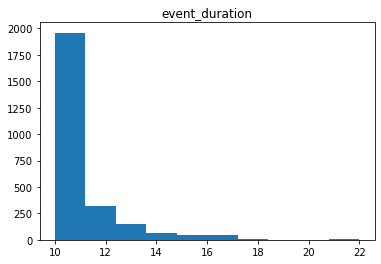

In [4]:
events.hist('event_duration', grid=False);

You can convert from the indices to coordinates using [climtas.event.event_coords](api/event.rst#climtas.event.event_coords). Events still active at the end of the dataset are marked with a duration of NaT (not a time)

In [5]:
coords = climtas.event.event_coords(da, events)

coords

,time,lat,lon,event_duration
0,2001-01-03,-5.510204,-136.8,10 days
1,2001-01-04,-86.326531,-136.8,11 days
2,2001-01-04,-56.938776,-104.4,11 days
3,2001-01-04,-16.530612,-158.4,11 days
4,2001-01-07,-90.000000,-158.4,10 days
...,...,...,...,...
2589,2003-12-11,23.877551,115.2,11 days
2590,2003-12-16,42.244898,104.4,11 days
2591,2003-12-18,34.897959,172.8,12 days
2592,2003-12-21,1.836735,104.4,10 days


To get statistics for each event use [climtas.event.map_events](api/event.rst#climtas.event.map_events). This takes a function that is given the event's data and returns a dict of different statistics. It's helpful to use `.values` here to return a number instead of a DataArray with coordinates and attributes.

In [6]:
stats = climtas.event.map_events(da, events, lambda x: {'sum': x.sum().values, 'mean': x.mean().values})

stats

,sum,mean
0,7.720646191765621,0.7720646191765621
1,7.545168908782278,0.6859244462529344
2,8.776404953284827,0.7978549957531661
3,8.820629283522708,0.8018753894111552
4,7.350620818505183,0.7350620818505182
...,...,...
2589,8.710790884253576,0.7918900803866887
2590,6.73266081786626,0.6120600743514782
2591,8.868592214995974,0.7390493512496645
2592,7.790211594277864,0.7790211594277864


Again this is a Pandas dataframe, so you can join the different tables really simply

In [7]:
coords.join(stats)

,time,lat,lon,event_duration,sum,mean
0,2001-01-03,-5.510204,-136.8,10 days,7.720646191765621,0.7720646191765621
1,2001-01-04,-86.326531,-136.8,11 days,7.545168908782278,0.6859244462529344
2,2001-01-04,-56.938776,-104.4,11 days,8.776404953284827,0.7978549957531661
3,2001-01-04,-16.530612,-158.4,11 days,8.820629283522708,0.8018753894111552
4,2001-01-07,-90.000000,-158.4,10 days,7.350620818505183,0.7350620818505182
...,...,...,...,...,...,...
2589,2003-12-11,23.877551,115.2,11 days,8.710790884253576,0.7918900803866887
2590,2003-12-16,42.244898,104.4,11 days,6.73266081786626,0.6120600743514782
2591,2003-12-18,34.897959,172.8,12 days,8.868592214995974,0.7390493512496645
2592,2003-12-21,1.836735,104.4,10 days,7.790211594277864,0.7790211594277864
